# `3.daphne`

In [20]:
from daphne import daphne
import os, json
import numpy as np
import torch
from torch import tensor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def ast_helper(fname,directory):
    sugared_fname = '../prob_prog/hw/hw6/CS532-HW6/{}/{}'.format(directory,fname)
    desugared_ast_json_fname = '/Users/gw/repos/prob_prog/' + sugared_fname.replace('.daphne','.json')
    if os.path.isfile(desugared_ast_json_fname):
        with open(desugared_ast_json_fname) as f:
            ast = json.load(f)
    else:
        #note: the sugared path that goes into daphne desugar should be with respect to the daphne path!
        ast = daphne(['desugar-hoppl-cps', '-i', sugared_fname]) 

        with open(desugared_ast_json_fname, 'w') as f:
            json.dump(ast, f)
    return ast

i=3
fname = '{}.daphne'.format(i)
exp = ast_helper(fname,directory='programs')
%cat programs/3.daphne

(defn reduce [f x values]
               (if (empty? values)
                  x
                  (reduce f (f x (first values)) (rest values))))

(let [observations [0.9 0.8 0.7 0.0 -0.025 -5.0 -2.0 -0.1 0.0 0.13 0.45 6 0.2 0.3 -1 -1]
      init-dist (discrete [1.0 1.0 1.0])
      trans-dists {0 (discrete [0.1 0.5 0.4])
                   1 (discrete [0.2 0.2 0.6])
                   2 (discrete [0.15 0.15 0.7])}
      obs-dists {0 (normal -1 1)
                 1 (normal 1 1)
                 2 (normal 0 1)}]
      (reduce
        (fn [states obs]
          (let [state (sample (get trans-dists
                                   (peek states)))]
            (observe (get obs-dists state) obs)
            (conj states state)))
        [(sample init-dist)]
        observations))


In [64]:
import smc, evaluator
import importlib
importlib.reload(smc)

<module 'smc' from '/Users/gw/repos/prob_prog/hw/hw6/CS532-HW6/smc.py'>

In [75]:
%%time
n_particles=100
logZ, particles = smc.SMC(n_particles, exp)
samples_array = torch.stack(particles).detach().numpy()
samples_array.mean(0)

CPU times: user 2.97 s, sys: 10.2 ms, total: 2.98 s
Wall time: 2.98 s


array([ 1.420,  1.600,  1.470,  1.480,  1.030,  1.540,  1.930,  1.930,
        1.730,  0.940,  0.260,  1.750,  1.670,  1.930,  2.000,  2.000,
        0.940])

CPU times: user 1h 4min 59s, sys: 18 s, total: 1h 5min 17s
Wall time: 1h 5min 26s


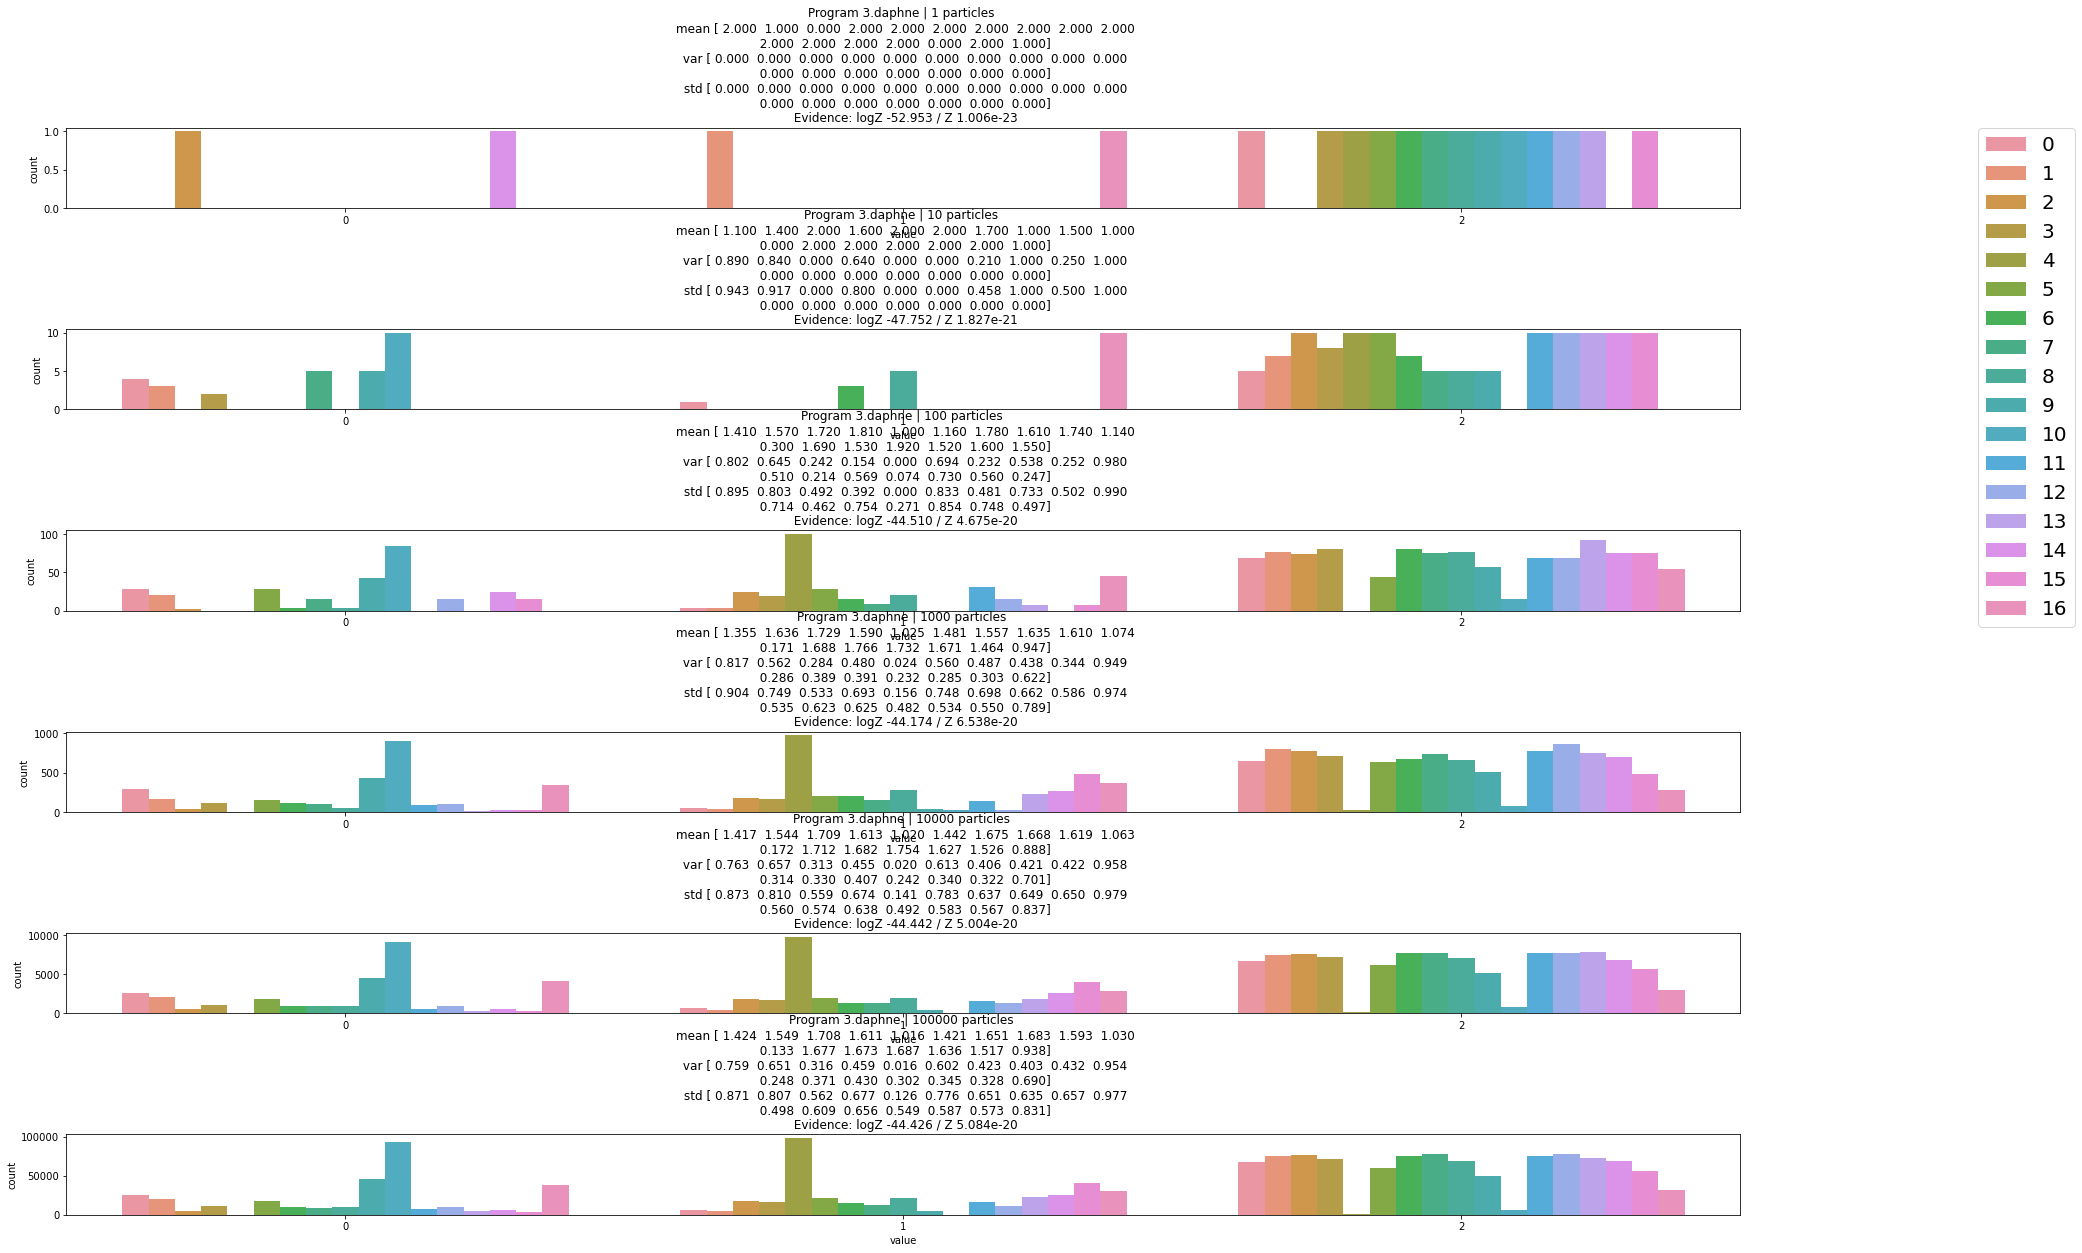

In [76]:
%%time
#40s / 1k samples
particle_counts = [1,10,100,1000,10000,100000]
fig, axes = plt.subplots(nrows=len(particle_counts),figsize=(30,20))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=1.75) # https://stackoverflow.com/questions/6541123/improve-subplot-size-spacing-with-many-subplots-in-matplotlib
np.set_printoptions(formatter={'float': '{: 1.3f}'.format}) # https://stackoverflow.com/questions/2891790/how-to-pretty-print-a-numpy-array-without-scientific-notation-and-with-given-pre

for idx, n_particles in enumerate(particle_counts):
    logZ, particles = smc.SMC(n_particles, exp)
    samples_array = torch.stack(particles).detach().numpy()
    
    # mean var
    mean = samples_array.mean(0)
    var = samples_array.var(0)
    title='Program {} | {} particles \n mean {} \n var {} \n std {} \n Evidence: logZ {:1.3f} / Z {:1.3e}'.format(
        fname, n_particles, mean, var, np.sqrt(var), logZ, np.exp(logZ))  
    
    df = pd.DataFrame(samples_array)
    df_wide = pd.melt(df.reset_index(),id_vars='index')
    ax1=sns.countplot(x="value", hue="variable", data=df_wide,ax=axes[idx])
    axes[idx].set_title(title)
    if idx == 0: 
        ax1.legend(bbox_to_anchor=(1.2, 1), loc='upper right', borderaxespad=0,fontsize=20)
    else:
        axes[idx].legend([],[], frameon=False)
